In [34]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F

# for reproducibility
torch.manual_seed(5492)

In [35]:
class VAE(nn.Module):
    def __init__(
          self,
          x_dim,
          hidden_dim,
          z_dim=10
        ):
        super(VAE, self).__init__()

        # Define autoencoding layers
        self.enc_layer1 = nn.Linear(x_dim, hidden_dim)
        self.enc_layer2_mu = nn.Linear(hidden_dim, z_dim)
        self.enc_layer2_logvar = nn.Linear(hidden_dim, z_dim)

        # Define autoencoding layers
        self.dec_layer1 = nn.Linear(z_dim, hidden_dim)
        self.dec_layer2 = nn.Linear(hidden_dim, x_dim)

    def encoder(self, x):
        x = F.relu(self.enc_layer1(x))
        mu = F.relu(self.enc_layer2_mu(x))
        logvar = F.relu(self.enc_layer2_logvar(x))
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar/2)
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z

    def decoder(self, z):
        # Define decoder network
        output = F.relu(self.dec_layer1(z))
        output = F.relu(self.dec_layer2(output))
        return output

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        output = self.decoder(z)
        return output, z, mu, logvar

# Define the loss function
def loss_function(output, x, mu, logvar):
    recon_loss = F.mse_loss(output, x, reduction='sum') / x.size(0)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + 0.002  * kl_loss


def train_model(
    model,
    dataloader,
    learning_rate=1e-4,
    num_epochs=15
  ):

  # Define the optimizer
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # Train the model
  for epoch in range(num_epochs):
      epoch_loss = 0
      for batch in dataloader:
          # Zero the gradients
          optimizer.zero_grad()

          # Get batch
          x = batch[0]

          # Forward pass
          output, z, mu, logvar = model(x)

          # Calculate loss
          loss = loss_function(output, x, mu, logvar)

          # Backward pass
          loss.backward()

          # Update parameters
          optimizer.step()

          # Add batch loss to epoch loss
          epoch_loss += loss.item()

      # Print epoch loss
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader.dataset)}")

  return model

In [36]:
def load_test_data():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
    mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)
    return test_loader


def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    with torch.no_grad():  # Disable gradient computation
        for batch in test_loader:
            x, _ = batch
            x = x.view(x.size(0), -1)  # Flatten the images

            # Forward pass
            output, z, mu, logvar = model(x)
            loss = loss_function(output, x, mu, logvar)
            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss}")

In [37]:
import matplotlib.pyplot as plt

def visualize_reconstruction(model, test_loader, num_images=10):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for batch in test_loader:
            x, _ = batch
            x = x.view(x.size(0), -1)  # Flatten the images

            # Forward pass
            output, _, _, _ = model(x)
            break  # We only need a single batch for visualization

    # Plot the original and reconstructed images
    x = x.view(-1, 28, 28)
    output = output.view(-1, 28, 28)
    fig, axes = plt.subplots(2, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[0, i].imshow(x[i].cpu().numpy(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(output[i].cpu().numpy(), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

In [38]:
def main() :
  # Load MNIST dataset
  transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
  mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
  dataloader = DataLoader(mnist_train, batch_size=128, shuffle=True)

  # Define the VAE model
  x_dim = 28 * 28  # MNIST images are 28x28
  hidden_dim = 256
  latent_dim = 50
  model = VAE(x_dim=x_dim, hidden_dim=hidden_dim, z_dim=latent_dim)

  # Train the model
  trained_model = train_model(model, dataloader, learning_rate=1e-4, num_epochs=15)

  # Load test data
  test_loader = load_test_data()

  # Test the VAE model
  test_model(trained_model, test_loader)

  # Visualize reconstructions
  visualize_reconstruction(trained_model, test_loader, num_images=10)

Epoch 1/15, Loss: 0.43091831919352214
Epoch 2/15, Loss: 0.32431233711242674
Epoch 3/15, Loss: 0.3007582618713379
Epoch 4/15, Loss: 0.2882534417470296
Epoch 5/15, Loss: 0.28026135991414386
Epoch 6/15, Loss: 0.27442574806213377
Epoch 7/15, Loss: 0.26987535429000853
Epoch 8/15, Loss: 0.26589983406066897
Epoch 9/15, Loss: 0.26317848755518597
Epoch 10/15, Loss: 0.26071113052368167
Epoch 11/15, Loss: 0.258353687953949
Epoch 12/15, Loss: 0.2564248909632365
Epoch 13/15, Loss: 0.2545415186882019
Epoch 14/15, Loss: 0.2529731690088908
Epoch 15/15, Loss: 0.2509222561518351
Test Loss: 0.2503498048782349


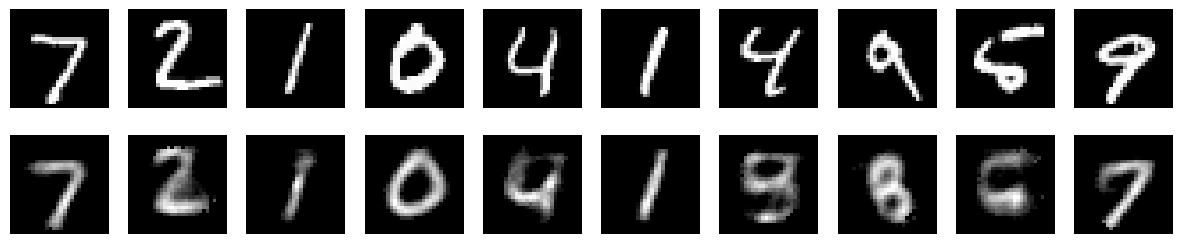

In [40]:
if __name__ == "__main__":
    main()